In [35]:
from board import Board
from placement import generate_queen_positions
from scorer import Scorer
from colour import ColourSpread
from visualisation import display_board

def main(n):
    """Generate, fill, and evaluate an N x N board."""
    boards = []
    for i in range(100):
        if i % 10 == 0:
            print(f"Generating board {i}...")
        board = Board(n)
        queen_positions = generate_queen_positions(n)
        board.place_queens(queen_positions)
        board.spread_colours(ColourSpread.random_spread)

        score = Scorer.evaluate_board(board)
        boards.append((board, score))

    return sorted(boards, key=lambda x: x[1])

In [36]:
sorted_boards = main(6)

Generating board 0...
Generating board 10...
Generating board 20...
Generating board 30...
Generating board 40...
Generating board 50...
Generating board 60...
Generating board 70...
Generating board 80...
Generating board 90...


In [40]:
sorted_boards[4]

(<board.Board at 0x236fc3a04d0>, 2)

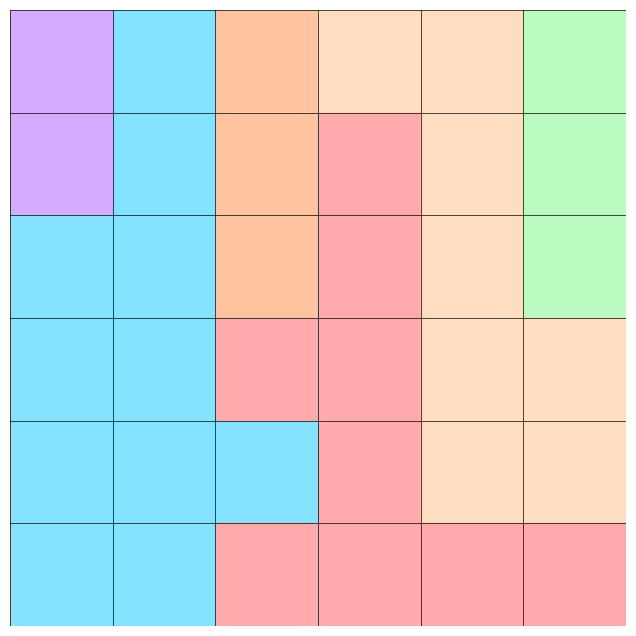

In [41]:
display_board(sorted_boards[4][0].grid)

In [16]:
from solver import QueensSolver

In [18]:
sorted_boards[0][0]

In [25]:
import numpy as np
import pulp

In [42]:
class QueensSolver:
    def __init__(self, queens_board: Board):
        self.board = queens_board.grid
        self.board_size = self.board.shape[0]
        given_sol = np.zeros((self.board_size, self.board_size), dtype=int)
        for queen in queens_board.queens:
            given_sol[queen.x, queen.y] = 1
        self.solutions = [given_sol]
        self.solutions = []
        self.colours = list(range(1, self.board_size + 1))
        self.rows = self.cols = range(self.board_size)

    def create_problem(self):
        self.prob = pulp.LpProblem("Queens", pulp.LpMinimize)
        self.choices = pulp.LpVariable.dicts(name="Queen", indices=(self.rows, self.cols), cat="Binary")
        self.constraints = []

    def row_constraints(self):
        return [pulp.lpSum([self.choices[r][c] for r in self.rows]) == 1 for c in self.cols]

    def col_constraints(self):
        return [pulp.lpSum([self.choices[r][c] for c in self.cols]) == 1 for r in self.rows]

    def colour_constraints(self):
        return [
            pulp.lpSum([self.choices[i][j] for i, j in zip(*np.where(self.board == colour))]) == 1
            for colour in self.colours
        ]

    def adjacent_indices(self):
        return {
            frozenset([(x, y), (x + dx, y + dy)])
            for x in self.rows
            for y in self.cols
            for dx in (-1, 0, 1)
            for dy in (-1, 0, 1)
            if (not dx == dy == 0) and x + dx in self.rows and y + dy in self.cols
        }

    def adjacency_constraints(self):
        return [self.choices[i][j] + self.choices[k][l] <= 1 for (i, j), (k, l) in self.adjacent_indices()]

    def zero_constraints(self):
        return [self.choices[i][j] == 0 for i in self.rows for j in self.cols if self.board[i][j] == 0]

    def prev_solution_constraints(self):
        return [
            pulp.lpSum([sol[i][j] for i in self.rows for j in self.cols if pulp.value(sol[i][j]) == 1])
            <= self.board_size - 1
            for sol in self.solutions
        ]

    def solve(self, max_solutions=1):
        self.create_problem()
        self.constraints = (
            self.row_constraints()
            + self.col_constraints()
            + self.colour_constraints()
            + self.adjacency_constraints()
            + self.zero_constraints()
            + self.prev_solution_constraints()
        )

        for constraint in self.constraints:
            self.prob += constraint
        for _ in range(max_solutions):
            self.prob.solve(pulp.PULP_CBC_CMD(msg=False))
            if self.prob.status != 1:
                break
            self.solutions.append(np.array([[pulp.value(self.choices[i][j]) for j in self.cols] for i in self.rows]))
            self.prob += (
                pulp.lpSum(
                    [self.choices[i][j] for i in self.rows for j in self.cols if pulp.value(self.choices[i][j]) == 1]
                )
                <= len(self.rows) - 1
            )

        self.num_solutions = len(self.solutions)

In [43]:
solver = QueensSolver(sorted_boards[4][0])

In [44]:
solver.solve(100)

In [45]:
solver.solutions

[array([[0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.]]),
 array([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.]])]

In [46]:
test = sorted_boards[4][0]

In [ ]:
import random

def _backtrack(queen_placement: np.ndarray, queens_placement: np.ndarray, row: int) -> True:
    n = queen_placement.shape[0]
    if row >= n:
        return True

    cols = list(range(n))
    random.shuffle(cols)
    for col in cols:
        if _is_valid_placement(queen_placement, grid, row, col):
            queen_placement[row][col] = 1
            if _backtrack(queen_placement, row + 1):
                return True
            queen_placement[row][col] = 0
        print(queen_placement)
    return False


def _is_valid_placement(queen_placement: np.ndarray, grid: np.ndarray, row: int, col: int) -> bool:
    colour = grid[row][col]
    check_colour = np.sum([queen_placement[i][j] for i, j in zip(*np.where(grid == colour))]) == 0

    check_queens = not (
        queen_placement[max(row - 1, 0) : row + 2, max(col - 1, 0) : col + 2].any()
        or queen_placement[row].any()
        or queen_placement[:, col].any()
    )

    return check_colour and check_queens


def unique_solution(queens_board: Board) -> bool:
    """Check if a board has a unique solution."""
    queen_placement = np.zeros((queens_board.n, queens_board.n), dtype=int)
    for queen in queens_board.queens:
        queen_placement[queen.x, queen.y] = 1

    grid = queens_board.grid.copy()
    found = _backtrack(queen_placement, grid, 0)
    return queen_placement, found


In [ ]:
def _backtrack(queens_placement: np.ndarray, grid: np.ndarray, known_solution: np.ndarray, row: int) -> True:
    n = queens_placement.shape[0]
    if row >= n:
        return True

    cols = list(range(n))
    random.shuffle(cols)
    for col in cols:
        if _is_valid_placement(queens_placement, grid, known_solution, row, col):
            queens_placement[row][col] = 1
            if _backtrack(queens_placement, known_solution, grid, row + 1):
                return True
            queens_placement[row][col] = 0
    return False


def _is_valid_placement(queens_placement: np.ndarray, grid: np.ndarray, known_solution: np.ndarray, row: int, col: int) -> bool:
    colour = grid[row][col]
    check_colour = np.sum([queens_placement[i][j] for i, j in zip(*np.where(grid == colour))]) == 0

    check_queens = not (
        queens_placement[max(row - 1, 0) : row + 2, max(col - 1, 0) : col + 2].any()
        or queens_placement[row].any()
        or queens_placement[:, col].any()
    )

    new_placement = queens_placement.copy()
    new_placement[row][col] = 1
    check_not_known = not np.array_equal(new_placement, known_solution)
    check_not_known = True

    return check_colour and check_queens and check_not_known


def find_solutions(queens_board: Board) -> np.array:
    queens_placement = np.zeros((queens_board.n, queens_board.n), dtype=int)
    known_solution = np.zeros((queens_board.n, queens_board.n), dtype=int)
    for queen in queens_board.queens:
        known_solution[queen.x, queen.y] = 1
    grid = queens_board.grid.copy()
    found = _backtrack(queens_placement, grid, known_solution, 0)
    return queens_placement, found


In [68]:
given_sol = np.zeros((test.n, test.n), dtype=int)
for queen in test.queens:
    given_sol[queen.x, queen.y] = 1

In [69]:
given_sol

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [66]:
find_solutions(test)

array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [94]:
find_solutions(test)

(array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]),
 False)